<font size="+3">Time-series Generative Adversarial Network (TimeGAN)</font>

# Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from pathlib import Path
from tqdm import tqdm

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GRU, Dense, RNN, GRUCell, Input
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt
import seaborn as sns

# Experiment Path

In [4]:
results_path = Path('time_gan')
if not results_path.exists():
    results_path.mkdir()

In [5]:
experiment = 'TFG'

In [6]:
log_dir = results_path / f'experiment_{experiment}'
if not log_dir.exists():
    log_dir.mkdir(parents=True)

In [7]:
hdf_store = results_path / 'TimeSeriesGAN.h5'

# Prepare Data

## Parameters

In [8]:
seq_len = 24
n_seq = 20
batch_size = 128

In [9]:
tickers=['AAPL', 'MSFT','JNJ', 'AMZN','XOM', 'JPM', 'LQD', 'SHY','IEF', 'TLT','^GSPC', 
         '^DJI', '^IXIC', 'GC=F', 'CL=F','IWM','FCEL', 'GBPUSD=X', 'JPY=X', 'EURUSD=X']

In [10]:
def select_data():
    df = pd.read_hdf('data.h5', 'yfinance/data/real_data')
    df.to_hdf(hdf_store, 'data/real')

In [11]:
select_data()

## Plot Series

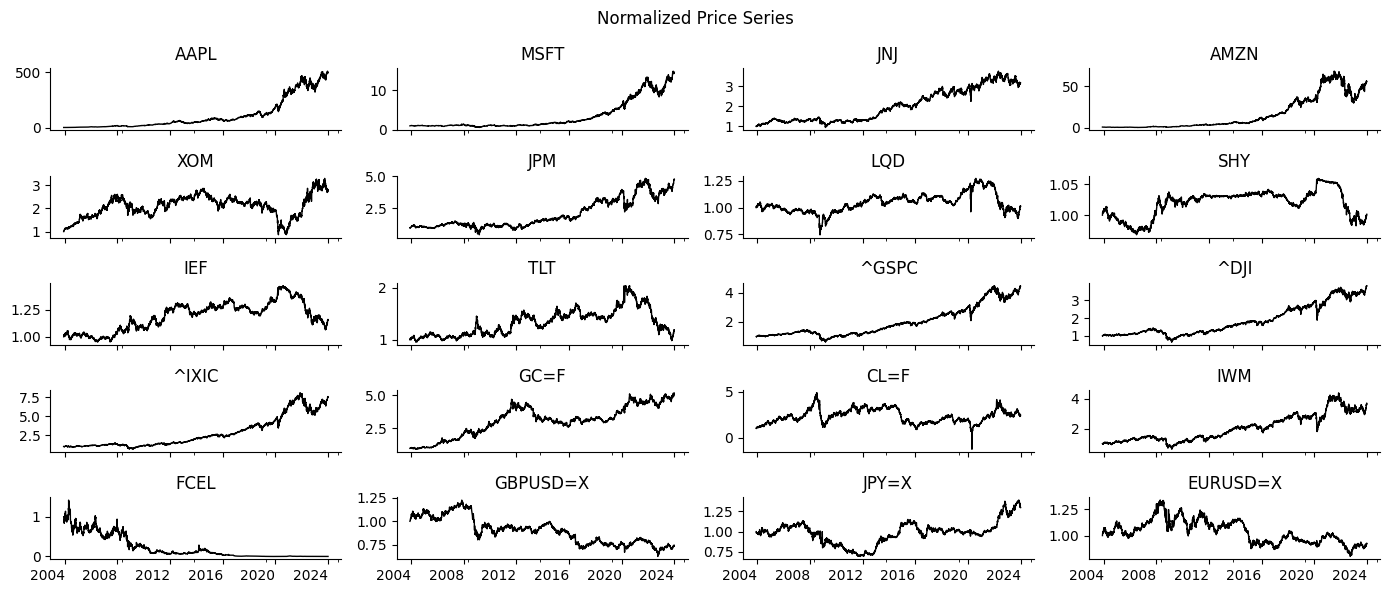

In [13]:
df = pd.read_hdf(hdf_store, 'data/real')
axes = df.div(df.iloc[0]).plot(subplots=True,
                               figsize=(14, 6),
                               layout=(5, 4),
                               title=tickers,
                               legend=False,
                               rot=0,
                               lw=1, 
                               color='k')
for ax in axes.flatten():
    ax.set_xlabel('')

plt.suptitle('Normalized Price Series')
plt.gcf().tight_layout()
sns.despine();

## Correlation

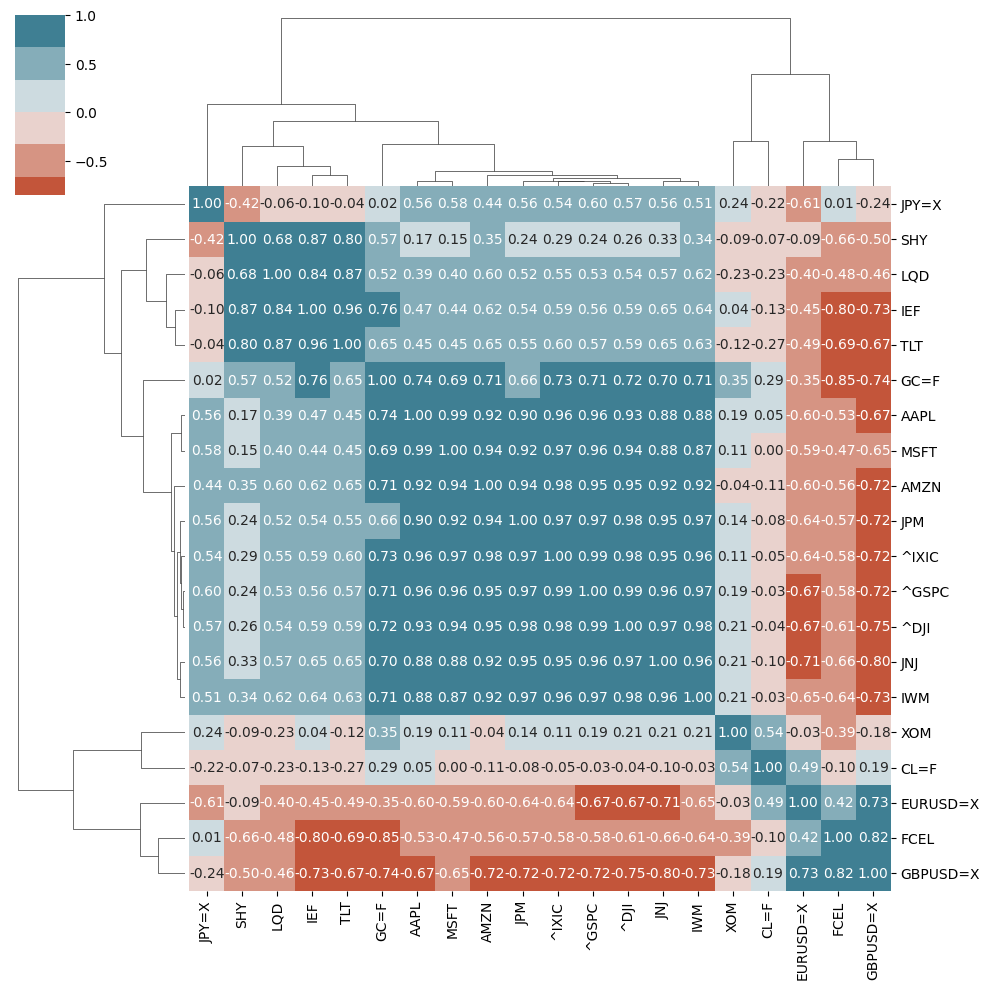

In [14]:
sns.clustermap(df.corr(),
               annot=True,
               fmt='.2f',
               cmap=sns.diverging_palette(h_neg=20,
                                          h_pos=220), center=0);

## Normalize Data

In [15]:
df = pd.read_hdf('data.h5', key='yfinance/data/real_data')
df.head()

,AAPL,MSFT,JNJ,AMZN,XOM,JPM,LQD,SHY,IEF,TLT,^GSPC,^DJI,^IXIC,GC=F,CL=F,IWM,FCEL,GBPUSD=X,JPY=X,EURUSD=X
Date,,,,,,,,,,,,,,,,,,,,
2003-12-01,0.387679,25.840000,49.500000,2.7325,36.389999,35.660000,109.389999,81.919998,83.599998,84.239998,1070.119995,9899.049805,1989.819946,402.700012,29.950001,55.430000,1977.119995,1.718597,109.169998,1.196501
2003-12-02,0.384643,25.660000,48.950001,2.6965,36.500000,35.810001,109.690002,82.010002,83.839996,84.599998,1066.619995,9853.639648,1980.069946,403.700012,30.780001,55.345001,1941.119995,1.730313,108.730003,1.208897
2003-12-03,0.375536,25.670000,49.160000,2.5755,36.540001,35.799999,109.500000,81.940002,83.620003,84.260002,1064.729980,9873.419922,1960.250000,403.899994,31.100000,54.349998,1951.199951,1.728101,108.300003,1.212298
2003-12-04,0.377679,26.200001,49.330002,2.5900,37.020000,35.389999,109.589996,82.019997,83.800003,84.449997,1069.719971,9930.820312,1968.800049,403.299988,31.260000,54.474998,1931.040039,1.720697,108.269997,1.208094
2003-12-05,0.372321,25.980000,49.160000,2.5780,36.779999,34.959999,110.730003,82.279999,84.820000,85.800003,1061.500000,9862.679688,1937.819946,406.399994,30.730000,53.799999,1877.760010,1.733102,107.620003,1.218695


In [16]:
# Determina el tamaño del conjunto de prueba
test_size = 0.2
split_index = int(len(df) * (1 - test_size))

# Divide el DataFrame en entrenamiento y prueba
train_df = df[:split_index]
test_df = df[split_index:]

In [17]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(train_df).astype(np.float32)

## Create rolling window sequences

In [18]:
data= np.load('scaled_real_train_data_array.npy')
N, T, D = data.shape
N, T, D

(3982, 24, 20)

In [19]:
n_windows = len(data)
n_windows

3982

## Create tf.data.Dataset

In [20]:
real_series = (tf.data.Dataset
               .from_tensor_slices(data)
               .shuffle(buffer_size=n_windows)
               .batch(batch_size))
real_series_iter = iter(real_series.repeat())

## Set up random series generator

In [21]:
def make_random_data():
    while True:
        yield np.random.uniform(low=0, high=1, size=(seq_len, n_seq))

In [22]:
random_series = iter(tf.data.Dataset
                     .from_generator(make_random_data, output_types=tf.float32)
                     .batch(batch_size)
                     .repeat())

# TimeGAN Components

##  Network Parameters

In [23]:
hidden_dim = 24
num_layers = 3

## Input place holders

In [24]:
X = Input(shape=[seq_len, n_seq], name='RealData')
Z = Input(shape=[seq_len, n_seq], name='RandomData')

## RNN block generator

In [25]:
def make_rnn(n_layers, hidden_units, output_units, name):
    return Sequential([GRU(units=hidden_units,
                           return_sequences=True,
                           name=f'GRU_{i + 1}') for i in range(n_layers)] +
                      [Dense(units=output_units,
                             activation='sigmoid',
                             name='OUT')], name=name)

## Embedder & Recovery

In [26]:
embedder = make_rnn(n_layers=3, 
                    hidden_units=hidden_dim, 
                    output_units=hidden_dim, 
                    name='Embedder')
recovery = make_rnn(n_layers=3, 
                    hidden_units=hidden_dim, 
                    output_units=n_seq, 
                    name='Recovery')

## Generator & Discriminator

In [27]:
generator = make_rnn(n_layers=3, 
                     hidden_units=hidden_dim, 
                     output_units=hidden_dim, 
                     name='Generator')
discriminator = make_rnn(n_layers=3, 
                         hidden_units=hidden_dim, 
                         output_units=1, 
                         name='Discriminator')
supervisor = make_rnn(n_layers=2, 
                      hidden_units=hidden_dim, 
                      output_units=hidden_dim, 
                      name='Supervisor')

# TimeGAN Training

## Settings

In [28]:
train_steps = 10000
gamma = 1

## Generic Loss Functions

In [29]:
mse = MeanSquaredError()
bce = BinaryCrossentropy()

# Phase 1: Autoencoder Training

## Architecture

In [30]:
H = embedder(X)
X_tilde = recovery(H)

autoencoder = Model(inputs=X,
                    outputs=X_tilde,
                    name='Autoencoder')

In [31]:
autoencoder.summary()

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RealData (InputLayer)       [(None, 24, 20)]          0         
                                                                 
 Embedder (Sequential)       (None, 24, 24)            11112     
                                                                 
 Recovery (Sequential)       (None, 24, 20)            11300     
                                                                 
Total params: 22412 (87.55 KB)
Trainable params: 22412 (87.55 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [32]:
plot_model(autoencoder,
           to_file=(results_path / 'autoencoder.png').as_posix(),
           show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Autoencoder Optimizer

In [33]:
autoencoder_optimizer = Adam()

## Autoencoder Training Step

In [34]:
@tf.function
def train_autoencoder_init(x):
    with tf.GradientTape() as tape:
        x_tilde = autoencoder(x)
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss_0 = 10 * tf.sqrt(embedding_loss_t0)

    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss_0, var_list)
    autoencoder_optimizer.apply_gradients(zip(gradients, var_list))
    return tf.sqrt(embedding_loss_t0)

## Autoencoder Training Loop

In [35]:
writer = tf.summary.create_file_writer(log_dir.as_posix())

In [36]:
for step in tqdm(range(train_steps)):
    X_ = next(real_series_iter)
    step_e_loss_t0 = train_autoencoder_init(X_)
    with writer.as_default():
        tf.summary.scalar('Loss Autoencoder Init', step_e_loss_t0, step=step)

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [08:50<00:00, 18.86it/s]


## Persist model

In [37]:
autoencoder.save(log_dir / 'autoencoder')

INFO:tensorflow:Assets written to: time_gan\experiment_TFG\autoencoder\assets


INFO:tensorflow:Assets written to: time_gan\experiment_TFG\autoencoder\assets


# Phase 2: Supervised training

## Define Optimizer

In [38]:
supervisor_optimizer = Adam()

## Train Step

In [39]:
@tf.function
def train_supervisor(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        g_loss_s = mse(h[:, 1:, :], h_hat_supervised[:, :-1, :])

    var_list = supervisor.trainable_variables
    gradients = tape.gradient(g_loss_s, var_list)
    supervisor_optimizer.apply_gradients(zip(gradients, var_list))
    return g_loss_s

## Training Loop

In [40]:
for step in tqdm(range(train_steps)):
    X_ = next(real_series_iter)
    step_g_loss_s = train_supervisor(X_)
    with writer.as_default():
        tf.summary.scalar('Loss Generator Supervised Init', step_g_loss_s, step=step)

100%|██████████| 10000/10000 [05:08<00:00, 32.38it/s]


## Persist Model

In [41]:
supervisor.save(log_dir / 'supervisor')

INFO:tensorflow:Assets written to: time_gan\experiment_TFG\supervisor\assets


INFO:tensorflow:Assets written to: time_gan\experiment_TFG\supervisor\assets


# Joint Training

## Generator

### Adversarial Architecture - Supervised

In [42]:
E_hat = generator(Z)
H_hat = supervisor(E_hat)
Y_fake = discriminator(H_hat)

adversarial_supervised = Model(inputs=Z,
                               outputs=Y_fake,
                               name='AdversarialNetSupervised')

In [43]:
adversarial_supervised.summary()

Model: "AdversarialNetSupervised"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomData (InputLayer)     [(None, 24, 20)]          0         
                                                                 
 Generator (Sequential)      (None, 24, 24)            11112     
                                                                 
 Supervisor (Sequential)     (None, 24, 24)            7800      
                                                                 
 Discriminator (Sequential)  (None, 24, 1)             10825     
                                                                 
Total params: 29737 (116.16 KB)
Trainable params: 29737 (116.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Adversarial Architecture in Latent Space

In [44]:
Y_fake_e = discriminator(E_hat)

adversarial_emb = Model(inputs=Z,
                    outputs=Y_fake_e,
                    name='AdversarialNet')

In [45]:
adversarial_emb.summary()

Model: "AdversarialNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomData (InputLayer)     [(None, 24, 20)]          0         
                                                                 
 Generator (Sequential)      (None, 24, 24)            11112     
                                                                 
 Discriminator (Sequential)  (None, 24, 1)             10825     
                                                                 
Total params: 21937 (85.69 KB)
Trainable params: 21937 (85.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Mean & Variance Loss

In [46]:
X_hat = recovery(H_hat)
synthetic_data = Model(inputs=Z,
                       outputs=X_hat,
                       name='SyntheticData')

In [47]:
synthetic_data.summary()

Model: "SyntheticData"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomData (InputLayer)     [(None, 24, 20)]          0         
                                                                 
 Generator (Sequential)      (None, 24, 24)            11112     
                                                                 
 Supervisor (Sequential)     (None, 24, 24)            7800      
                                                                 
 Recovery (Sequential)       (None, 24, 20)            11300     
                                                                 
Total params: 30212 (118.02 KB)
Trainable params: 30212 (118.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [48]:
def get_generator_moment_loss(y_true, y_pred):
    y_true_mean, y_true_var = tf.nn.moments(x=y_true, axes=[0])
    y_pred_mean, y_pred_var = tf.nn.moments(x=y_pred, axes=[0])
    g_loss_mean = tf.reduce_mean(tf.abs(y_true_mean - y_pred_mean))
    g_loss_var = tf.reduce_mean(tf.abs(tf.sqrt(y_true_var + 1e-6) - tf.sqrt(y_pred_var + 1e-6)))
    return g_loss_mean + g_loss_var

## Discriminator

### Architecture: Real Data

In [49]:
Y_real = discriminator(H)
discriminator_model = Model(inputs=X,
                            outputs=Y_real,
                            name='DiscriminatorReal')

In [50]:
discriminator_model.summary()

Model: "DiscriminatorReal"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RealData (InputLayer)       [(None, 24, 20)]          0         
                                                                 
 Embedder (Sequential)       (None, 24, 24)            11112     
                                                                 
 Discriminator (Sequential)  (None, 24, 1)             10825     
                                                                 
Total params: 21937 (85.69 KB)
Trainable params: 21937 (85.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Optimizers

In [51]:
generator_optimizer = Adam()
discriminator_optimizer = Adam()
embedding_optimizer = Adam()

## Generator Train Step

In [52]:
@tf.function
def train_generator(x, z):
    with tf.GradientTape() as tape:
        y_fake = adversarial_supervised(z)
        generator_loss_unsupervised = bce(y_true=tf.ones_like(y_fake),
                                          y_pred=y_fake)

        y_fake_e = adversarial_emb(z)
        generator_loss_unsupervised_e = bce(y_true=tf.ones_like(y_fake_e),
                                            y_pred=y_fake_e)
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_hat = synthetic_data(z)
        generator_moment_loss = get_generator_moment_loss(x, x_hat)

        generator_loss = (generator_loss_unsupervised +
                          generator_loss_unsupervised_e +
                          100 * tf.sqrt(generator_loss_supervised) +
                          100 * generator_moment_loss)

    var_list = generator.trainable_variables + supervisor.trainable_variables
    gradients = tape.gradient(generator_loss, var_list)
    generator_optimizer.apply_gradients(zip(gradients, var_list))
    return generator_loss_unsupervised, generator_loss_supervised, generator_moment_loss

## Embedding Train Step

In [53]:
@tf.function
def train_embedder(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_tilde = autoencoder(x)
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss = 10 * tf.sqrt(embedding_loss_t0) + 0.1 * generator_loss_supervised

    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss, var_list)
    embedding_optimizer.apply_gradients(zip(gradients, var_list))
    return tf.sqrt(embedding_loss_t0)

## Discriminator Train Step

In [54]:
@tf.function
def get_discriminator_loss(x, z):
    y_real = discriminator_model(x)
    discriminator_loss_real = bce(y_true=tf.ones_like(y_real),
                                  y_pred=y_real)

    y_fake = adversarial_supervised(z)
    discriminator_loss_fake = bce(y_true=tf.zeros_like(y_fake),
                                  y_pred=y_fake)

    y_fake_e = adversarial_emb(z)
    discriminator_loss_fake_e = bce(y_true=tf.zeros_like(y_fake_e),
                                    y_pred=y_fake_e)
    return (discriminator_loss_real +
            discriminator_loss_fake +
            gamma * discriminator_loss_fake_e)

In [55]:
@tf.function
def train_discriminator(x, z):
    with tf.GradientTape() as tape:
        discriminator_loss = get_discriminator_loss(x, z)

    var_list = discriminator.trainable_variables
    gradients = tape.gradient(discriminator_loss, var_list)
    discriminator_optimizer.apply_gradients(zip(gradients, var_list))
    return discriminator_loss

## Training Loop

In [56]:
step_g_loss_u = step_g_loss_s = step_g_loss_v = step_e_loss_t0 = step_d_loss = 0
for step in range(train_steps):
    # Train generator (twice as often as discriminator)
    for kk in range(2):
        X_ = next(real_series_iter)
        Z_ = next(random_series)

        # Train generator
        step_g_loss_u, step_g_loss_s, step_g_loss_v = train_generator(X_, Z_)
        # Train embedder
        step_e_loss_t0 = train_embedder(X_)

    X_ = next(real_series_iter)
    Z_ = next(random_series)
    step_d_loss = get_discriminator_loss(X_, Z_)
    if step_d_loss > 0.15:
        step_d_loss = train_discriminator(X_, Z_)

    if step % 1000 == 0:
        print(f'{step:6,.0f} | d_loss: {step_d_loss:6.4f} | g_loss_u: {step_g_loss_u:6.4f} | '
              f'g_loss_s: {step_g_loss_s:6.4f} | g_loss_v: {step_g_loss_v:6.4f} | e_loss_t0: {step_e_loss_t0:6.4f}')

    with writer.as_default():
        tf.summary.scalar('G Loss S', step_g_loss_s, step=step)
        tf.summary.scalar('G Loss U', step_g_loss_u, step=step)
        tf.summary.scalar('G Loss V', step_g_loss_v, step=step)
        tf.summary.scalar('E Loss T0', step_e_loss_t0, step=step)
        tf.summary.scalar('D Loss', step_d_loss, step=step)

     0 | d_loss: 2.0119 | g_loss_u: 0.7914 | g_loss_s: 0.0001 | g_loss_v: 0.4825 | e_loss_t0: 0.0440
 1,000 | d_loss: 1.8655 | g_loss_u: 1.1095 | g_loss_s: 0.0001 | g_loss_v: 0.0495 | e_loss_t0: 0.0275
 2,000 | d_loss: 1.8213 | g_loss_u: 1.0706 | g_loss_s: 0.0001 | g_loss_v: 0.0343 | e_loss_t0: 0.0270
 3,000 | d_loss: 1.5970 | g_loss_u: 1.0761 | g_loss_s: 0.0002 | g_loss_v: 0.0171 | e_loss_t0: 0.0255
 4,000 | d_loss: 1.6937 | g_loss_u: 1.3840 | g_loss_s: 0.0002 | g_loss_v: 0.0500 | e_loss_t0: 0.0252
 5,000 | d_loss: 1.7177 | g_loss_u: 1.3186 | g_loss_s: 0.0002 | g_loss_v: 0.0222 | e_loss_t0: 0.0221
 6,000 | d_loss: 1.6402 | g_loss_u: 1.3261 | g_loss_s: 0.0002 | g_loss_v: 0.0286 | e_loss_t0: 0.0221
 7,000 | d_loss: 1.6443 | g_loss_u: 1.2618 | g_loss_s: 0.0002 | g_loss_v: 0.0340 | e_loss_t0: 0.0212
 8,000 | d_loss: 1.5457 | g_loss_u: 1.1203 | g_loss_s: 0.0002 | g_loss_v: 0.0373 | e_loss_t0: 0.0202
 9,000 | d_loss: 1.6738 | g_loss_u: 1.1965 | g_loss_s: 0.0002 | g_loss_v: 0.0288 | e_loss_t

## Persist Synthetic Data Generator

In [57]:
synthetic_data.save(log_dir / 'synthetic_data')

INFO:tensorflow:Assets written to: time_gan\experiment_TFG\synthetic_data\assets


INFO:tensorflow:Assets written to: time_gan\experiment_TFG\synthetic_data\assets


# Generate Synthetic Data

In [69]:
int(n_windows / batch_size)

31

In [73]:
generated_data = []
for i in range(int(n_windows / batch_size)):
    Z_ = next(random_series)
    d = synthetic_data(Z_)
    generated_data.append(d)

In [74]:
generated_data = []
for i in range(39):
    Z_ = next(random_series)
    d = synthetic_data(Z_)
    generated_data.append(d)

In [75]:
len(generated_data)

39

In [76]:
generated_data = np.array(np.vstack(generated_data))
generated_data.shape

(4992, 24, 20)

In [77]:
np.save(log_dir / 'generated_data.npy', generated_data)

In [78]:
np.save('scaled_synthetic_data_array_gan.npy', generated_data)

## Rescale

In [79]:
generated_data = (scaler.inverse_transform(generated_data
                                           .reshape(-1, n_seq))
                  .reshape(-1, seq_len, n_seq))
generated_data.shape

(4992, 24, 20)

In [80]:
np.save('synthetic_data_array_gan.npy', generated_data)

## Persist Data

In [81]:
with pd.HDFStore(hdf_store) as store:
    store.put('data/synthetic', pd.DataFrame(generated_data.reshape(-1, n_seq),
                                             columns=tickers))

## Plot sample Series

In [82]:
tickers=['AAPL', 'MSFT','JNJ', 'AMZN','XOM', 'JPM', 'LQD', 'SHY','IEF', 'TLT','^GSPC', 
         '^DJI', '^IXIC', 'GC=F', 'CL=F','IWM','FCEL', 'GBPUSD=X', 'JPY=X', 'EURUSD=X']

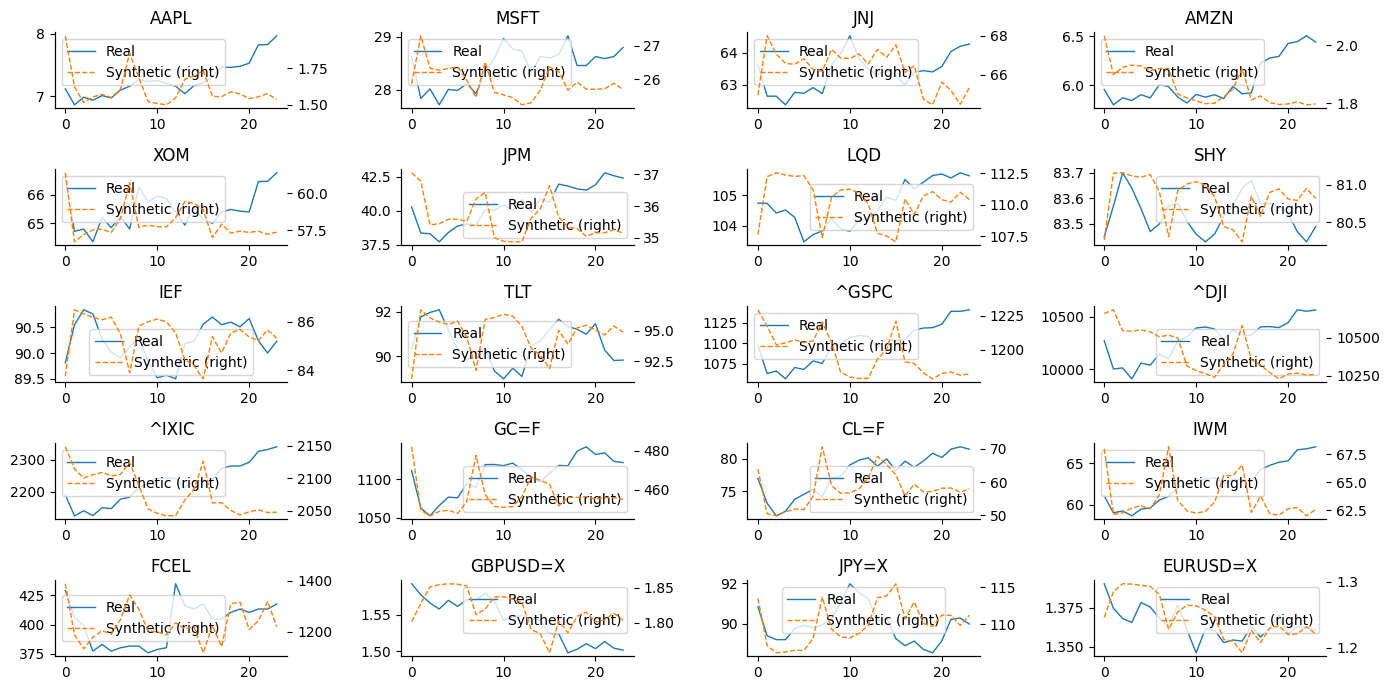

In [83]:
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(14, 7))
axes = axes.flatten()

index = list(range(1, 25))
synthetic = generated_data[np.random.randint(n_windows)]

idx = np.random.randint(len(df) - seq_len)
real = df.iloc[idx: idx + seq_len]

for j, ticker in enumerate(tickers):
    (pd.DataFrame({'Real': real.iloc[:, j].values,
                   'Synthetic': synthetic[:, j]})
     .plot(ax=axes[j],
           title=ticker,
           secondary_y='Synthetic', style=['-', '--'],
           lw=1))
sns.despine()
fig.tight_layout()
plt.savefig('distribucion_gan.png')